In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sym import CNN, Augment, ProgressBar
device = "cuda:0" if torch.cuda.is_available() else "cpu"
plt.style.use("dark_paper")

In [2]:
#transform = torchvision.transforms.Pad((280,280))
imagenet_data_train = torchvision.datasets.MNIST("./data/", train=True)  # transform=
imagenet_data_val = torchvision.datasets.MNIST("./data/", train=False)

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
transform = transforms.Compose([transforms.CenterCrop((24,20)),
                                transforms.Resize((24,8)),
                               ])
n_digits = 5
data = transform(imagenet_data_train.data).view(-1,n_digits,24,8)
data = data.permute(1,3,2,0).contiguous().view(8*n_digits,24,-1)
data = data.permute(2,1,0).unsqueeze(1)/255
targets = imagenet_data_train.targets.view(-1,5)[:,1:-1].sum(axis=1)%2
targets = 2*targets -1 
trainloader =torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data.float(),targets.float()),
                                          batch_size=16,
                                          shuffle=True)

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
data = transform(imagenet_data_val.data).view(-1,n_digits,24,8)
data = data.permute(1,3,2,0).contiguous().view(8*n_digits,24,-1)
data = data.permute(2,1,0).unsqueeze(1)/255
targets = imagenet_data_val.targets.view(-1,5)[:,1:-1].sum(axis=1)%2
targets = 2*targets -1 
valloader =torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data.float(),targets.float()),
                                          batch_size=16,
                                          shuffle=True)

tensor(-1.)


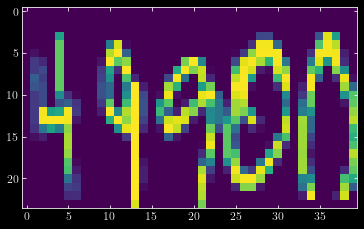

tensor(1.)


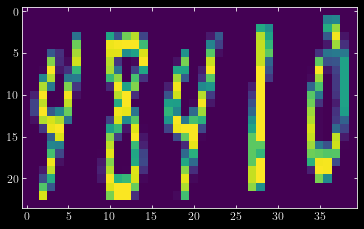

tensor(1.)


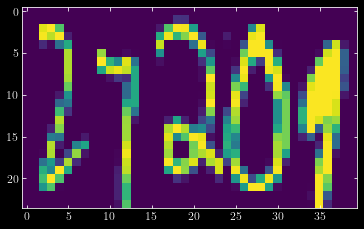

tensor(1.)


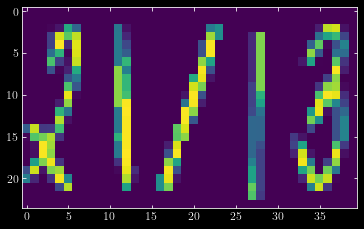

tensor(-1.)


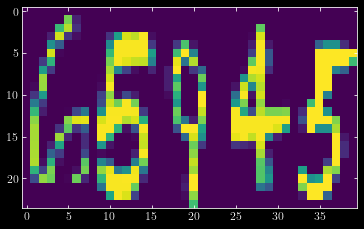

tensor(1.)


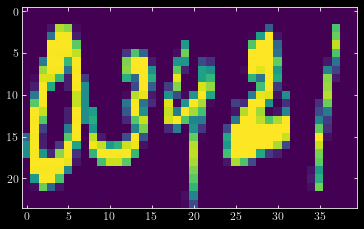

tensor(1.)


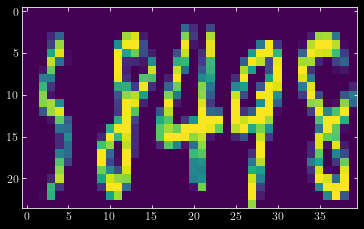

tensor(1.)


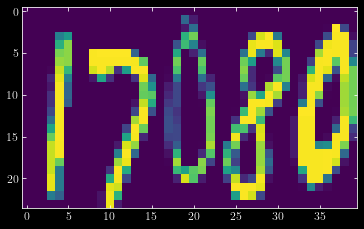

tensor(-1.)


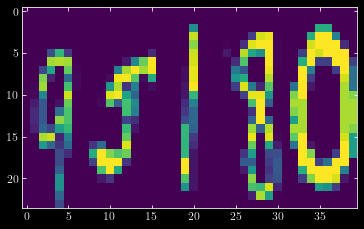

tensor(-1.)


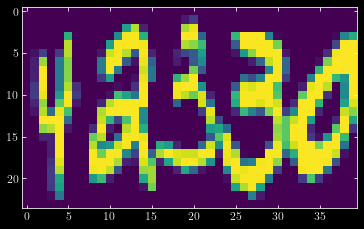

In [64]:
xs,ys =  iter(trainloader).next()
i = 0
for x,y in zip(xs,ys):
    i+=1
    print(y)
    plt.imshow(x[0])
    plt.show()
    if i ==10:
        break

In [ ]:
# Define metrics function
def metrics(model):
    with torch.no_grad():
        model.eval()
        model.to(device)
        yhat = []
        targets = []
        for x, y in valloader:
            x = x.to(device)
            yhat.append(model(x).cpu().numpy())
            targets.append(y.cpu().numpy())
    yhat = np.concatenate(yhat)
    targets = np.concatenate(targets)
    out = classification_report(targets, np.sign(yhat))
    print(out)
def plot_loss():
    plt.plot(np.arange(0, T), losses_train[0:], label="Train")
    plt.plot(np.arange(0, T, log_step), losses_val, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Data
The validation set is made of digits located somewhere in a 10x10 grid. The training data, on the otherhand, is always located in the top left corner.

In [6]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

In [77]:
nfilters = 1024
from torchsummary import summary
fcn = torch.nn.Sequential(torch.nn.Flatten(),
                          torch.nn.Linear(24*8*n_digits, nfilters), #* more for full fcn width
                          #torch.nn.BatchNorm1d(nfilters*(10)**2),
                          torch.nn.ReLU(),
                          #torch.nn.MaxPool1d(100,100),
                          torch.nn.Linear(nfilters, nfilters),
                          torch.nn.Linear(nfilters, nfilters),
                          torch.nn.Linear(nfilters, nfilters),
                          torch.nn.Linear(nfilters, nfilters),
                          torch.nn.Linear(nfilters, nfilters),
                          torch.nn.Linear(nfilters, 1),
                          torch.nn.Tanh(),)
cnn = torch.nn.Sequential(torch.nn.Conv2d(1, nfilters, kernel_size=24, stride=8),
                          torch.nn.BatchNorm2d(nfilters),
                          torch.nn.ReLU(),
                          #torch.nn.MaxPool2d((10, 1)),
                          torch.nn.Flatten(),
                          torch.nn.Linear(nfilters*3, 1), #(8*n_digits-24+8)
                          torch.nn.Tanh(),
                         )  # (10)**2
criterion = torch.nn.MSELoss()
#summary(cnn.cuda(),(1,24,8*5))

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Training some models 

In [68]:
T = 30  # epochs
log_step = 1  # validate and print losses every log_steps

In [69]:
# Define training and validation functions
def train(model, x, y):
    x = x.to(device)
    y = y.to(device)
    model.train()
    yhat = model(x)
    loss = criterion(yhat, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()
def validate(model, x, y):
    x = x.to(device)
    y = y.to(device)
    model.eval()
    with torch.no_grad():
        yhat = model(x)
        loss = criterion(yhat, y)
        return loss.item()

In [71]:
def train_loop(model, T=10, log_step=1):
    losses_train = []
    losses_val = []
    model.train()
    total_steps = len(trainloader)
    for t in range(1, T+1):
        loss = list()  # Combine losses from differetn steps in a single epoch
        # Training Step
        for step, (x, y) in enumerate(trainloader):
            loss_ = train(model, x, y)
            loss.append(loss_)
            print(
                f"Epoch {t:>03d}/{T:^3d} [Step {step+1}/{total_steps}] | Training loss: {loss_:^.4f}", end="\r")
        loss = np.mean(loss)
        losses_train.append(loss)
        # Validation Step
        if t % log_step == 0:
            message = f"Epoch {t:>03d}/{T:^3d} | Training loss: {loss:^.4f} - "
            loss = []
            with torch.no_grad():
                for x, y in valloader:
                    loss_ = validate(model, x, y)
                    loss.append(loss_)
            loss = np.mean(loss)
            losses_val.append(loss)
            message += f"Validation loss: {loss:^.4f}"
            print(message)  # ,end="\r"
    return losses_train, losses_val

#  CNN Training

In [73]:
# Train the CNN for 100 epochs
cnn.to(device)
optimizer = torch.optim.SGD(cnn.parameters(),lr=1e-2)
losses_train, losses_val = train_loop(cnn,T=T,log_step=log_step)

Epoch 001/30  | Training loss: 2.0163 - Validation loss: 2.0880
Epoch 002/30  | Training loss: 2.0163 - Validation loss: 2.0880
Epoch 003/30  | Training loss: 2.0163 - Validation loss: 2.0880
Epoch 004/30  | Training loss: 2.0163 - Validation loss: 2.0880
Epoch 005/30  | Training loss: 2.0163 - Validation loss: 2.0880
Epoch 006/30  | Training loss: 2.0163 - Validation loss: 2.0880
Epoch 007/30  | Training loss: 2.0163 - Validation loss: 2.0880
Epoch 008/30  | Training loss: 2.0163 - Validation loss: 2.0880
Epoch 009/30  | Training loss: 2.0163 - Validation loss: 2.0880
Epoch 010/30  | Training loss: 2.0163 - Validation loss: 2.0880
Epoch 011/30  | Training loss: 2.0163 - Validation loss: 2.0880
Epoch 012/30  | Training loss: 2.0163 - Validation loss: 2.0880
Epoch 013/30  | Training loss: 2.0163 - Validation loss: 2.0880
Epoch 014/30  | Training loss: 2.0163 - Validation loss: 2.0880
Epoch 015/30  | Training loss: 2.0163 - Validation loss: 2.0880
Epoch 016/30  | Training loss: 2.0163 - 

In [74]:
cnn(xs.cuda())

tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<TanhBackward>)

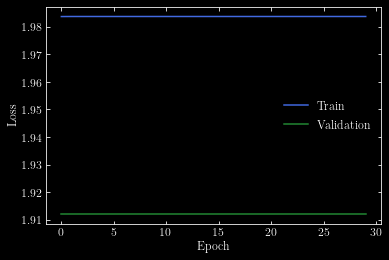

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       956
         1.0       0.52      1.00      0.69      1044

    accuracy                           0.52      2000
   macro avg       0.26      0.50      0.34      2000
weighted avg       0.27      0.52      0.36      2000



/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
plot_loss()
metrics(cnn)

# LCN Training

In [14]:
# lcn = LCN()
# lcn.to(device)

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# optimizer = torch.optim.Adam(lcn.parameters(), lr=1e-2)
# losses_train, losses_val = train_loop(lcn, T=T, log_step=log_step)

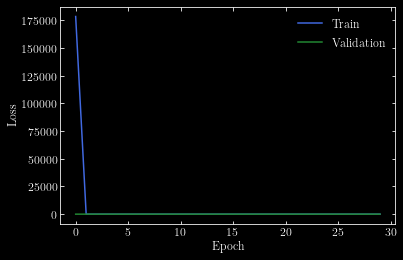

NameError: name 'lcn' is not defined

In [16]:
plot_loss()
metrics(lcn)

# FCN Training

In [81]:
fcn = torch.nn.Sequential(torch.nn.Flatten(),
                          torch.nn.Linear(24*8*n_digits, nfilters), #* more for full fcn width
                          #torch.nn.BatchNorm1d(nfilters*(10)**2),
                          torch.nn.ReLU(),
                          #torch.nn.MaxPool1d(100,100),
                          torch.nn.Linear(nfilters, nfilters),
                          torch.nn.ReLU(),
                          torch.nn.Linear(nfilters, nfilters),
                          torch.nn.ReLU(),
                          torch.nn.Linear(nfilters, nfilters),
                          torch.nn.ReLU(),
                          torch.nn.Linear(nfilters, nfilters),
                          torch.nn.ReLU(),
                          torch.nn.Linear(nfilters, nfilters),
                          torch.nn.ReLU(),
                          torch.nn.Linear(nfilters, 1),
                          torch.nn.Tanh(),)
fcn.to(device)
optimizer = torch.optim.SGD(fcn.parameters(), lr=1e-2)
losses_train, losses_val = train_loop(fcn, T=T, log_step=log_step)

Epoch 001/30  | Training loss: 1.0008 - Validation loss: 0.9985
Epoch 002/30  | Training loss: 1.0003 - Validation loss: 1.0106
Epoch 003/30  | Training loss: 1.0010 - Validation loss: 1.0059
Epoch 004/30  | Training loss: 1.0005 - Validation loss: 1.0023
Epoch 005/30  | Training loss: 1.0011 - Validation loss: 0.9981
Epoch 006/30  | Training loss: 1.0011 - Validation loss: 0.9996
Epoch 007/30  | Training loss: 1.0010 - Validation loss: 0.9981
Epoch 008/30  | Training loss: 1.0010 - Validation loss: 0.9986
Epoch 009/30  | Training loss: 1.0010 - Validation loss: 1.0013
Epoch 010/30  | Training loss: 1.0010 - Validation loss: 0.9993
Epoch 011/30  | Training loss: 1.0008 - Validation loss: 0.9984
Epoch 012/30  | Training loss: 1.0007 - Validation loss: 0.9981
Epoch 013/30  | Training loss: 1.0010 - Validation loss: 0.9981
Epoch 014/30  | Training loss: 1.0009 - Validation loss: 0.9983
Epoch 015/30  | Training loss: 1.0007 - Validation loss: 0.9984
Epoch 016/30  | Training loss: 1.0007 - 

In [82]:
plot_loss()
metrics(fcn)

KeyboardInterrupt: 